<a href="https://colab.research.google.com/github/Auzek2002/Fashion_Items_Classification_System/blob/main/Fashion_Items_Classification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libs:

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

# Installing Keras Tuner (for hp tuning)

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
print(tf.__version__)

2.15.0


# Loading the DataSet

In [ ]:
fashion_dataSet = datasets.fashion_mnist

In [ ]:
(x_train,y_train) , (x_test,y_test) = fashion_dataSet.load_data()

4422102/4422102 [==============================] - 1s 0us/step


# Exploring the DataSet

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
y_test.shape

(10000,)

## **There are 60,000 training examples and 10,000 testing examples. Each image is a 28 x 28 pixel image**

# Displaying some Images

In [ ]:
class_names= ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

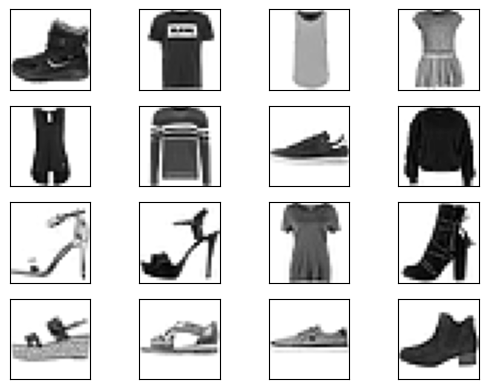

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i],cmap=plt.cm.binary)

# Normalizing the Data

In [ ]:
print(f"Max pixel value is: {np.max(x_train)} and Mix pixel value is: {np.min(x_train)}")

Max pixel value is: 255 and Mix pixel value is: 0


In [ ]:
#divide by 255 to normalize the data:
x_train , x_test = x_train/255.0 , x_test/255.0

# Reshaping the images

In [ ]:
x_train = x_train.reshape(len(x_train),28,28,1)
x_test = x_test.reshape(len(x_test),28,28,1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
x_test.shape

(10000, 28, 28, 1)

# Choosing the best model using keras tuner

In [ ]:
def build_model(hp):
  model = Sequential([
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=8, max_value=512, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation=hp.Choice('conv_1_activation',values= ['relu','selu','tanh','elu','sigmoid']),
        input_shape=(28,28,1)
    ),
    MaxPooling2D((2,2)),
    layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=8, max_value=128, step=8),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation=hp.Choice('conv_2_activation',values= ['relu','selu','tanh','elu','sigmoid'])
    ),
    MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=512, step=16),
        activation=hp.Choice('dense_1_activation',values= ['relu','selu','tanh','elu','sigmoid'])
    ),
    layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.0001,0.0003,0.001,0.003,0.01])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

## **Search for the best Hyperparameters**

In [ ]:
tuner_search = RandomSearch(build_model,objective='val_accuracy',max_trials=8,directory='output',project_name='Fashion_items_Classification_System')

In [ ]:
tuner_search.search(x_train,y_train,epochs=3,validation_split=0.1)

Trial 8 Complete [00h 00m 43s]
val_accuracy: 0.8803333044052124

Best val_accuracy So Far: 0.8995000123977661
Total elapsed time: 00h 05m 32s


## **Extracting the best model**

In [ ]:
model = tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 232)       6032      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 232)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 56)        116984    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 56)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1400)              0         
                                                                 
 dense (Dense)               (None, 208)               2

# Fitting the Model

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,initial_epoch=3)

Epoch 4/5
1875/1875 [==============================] - 10s 4ms/step - loss: 0.2508 - accuracy: 0.9073 - val_loss: 0.2870 - val_accuracy: 0.8927
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2269 - accuracy: 0.9161 - val_loss: 0.2781 - val_accuracy: 0.9010


In [ ]:
score = model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2781 - accuracy: 0.9010


In [ ]:
print(f"Accuracy of the model is: {score[1]*100:0.2f}%")

Accuracy of the model is: 90.10%
